In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'BNB'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/Resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,2.05314,2.17423,1.89394,1.99077,1.99077,19192200.0
2017-11-10,2.00773,2.06947,1.64478,1.79684,1.79684,11155000.0
2017-11-11,1.78628,1.91775,1.61429,1.67047,1.67047,8178150.0
2017-11-12,1.66889,1.67280,1.46256,1.51969,1.51969,15298700.0
2017-11-13,1.52601,1.73502,1.51760,1.68662,1.68662,12238800.0


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-14,591.606934,592.836975,563.420227,566.707031,566.707031,1.944063e+09
2024-05-15,566.707031,587.421509,561.127258,582.074341,582.074341,1.895100e+09
2024-05-16,582.100159,586.436340,565.762329,569.190247,569.190247,1.911862e+09
2024-05-17,569.190247,584.666016,568.836731,581.178345,581.178345,1.557135e+09
2024-05-19,580.487366,580.487366,580.226868,580.305542,580.305542,1.354966e+09


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

580.305542

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998960,0.998342,0.997832,0.997832,0.640647
High,0.998960,1.000000,0.997670,0.998914,0.998914,0.661331
Low,0.998342,0.997670,1.000000,0.998786,0.998786,0.619755
Close,0.997832,0.998914,0.998786,1.000000,1.000000,0.645281
Adj Close,0.997832,0.998914,0.998786,1.000000,1.000000,0.645281
Volume,0.640647,0.661331,0.619755,0.645281,0.645281,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2017-11-09,1.990770,1.919220e+07
2017-11-10,1.796840,1.115500e+07
2017-11-11,1.670470,8.178150e+06
2017-11-12,1.519690,1.529870e+07
2017-11-13,1.686620,1.223880e+07
...,...,...
2024-05-14,566.707031,1.944063e+09
2024-05-15,582.074341,1.895100e+09
2024-05-16,569.190247,1.911862e+09


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2017-12-28,9.32141,109298000.0,6.562748,4.183277,3.186518
2017-12-29,8.80760,70849400.0,6.864275,4.418480,3.322854
2017-12-30,7.84101,72933904.0,7.130755,4.613281,3.443738
2017-12-31,8.63558,74927904.0,7.476312,4.832126,3.583040
2018-01-01,8.41461,66422800.0,7.884158,5.043141,3.720938


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-14,566.707031,1.944063e+09,587.272058,581.653263,582.645928
2024-05-15,582.074341,1.895100e+09,586.265454,582.626591,582.684404
2024-05-16,569.190247,1.911862e+09,584.336884,583.671954,582.577977
2024-05-17,581.178345,1.557135e+09,584.706098,585.230699,582.536127
2024-05-19,580.305542,1.354966e+09,583.916907,586.168479,581.889078


<Axes: xlabel='Date'>

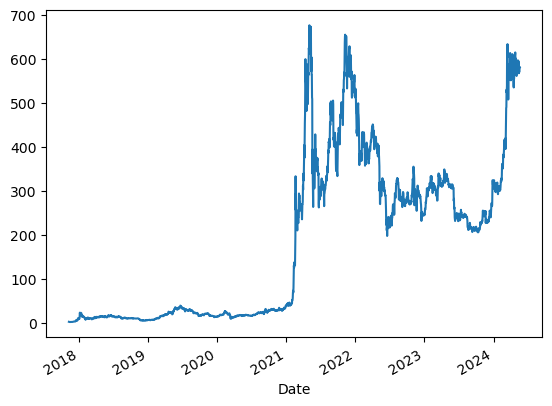

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2017-11-09,1.990770,1.919220e+07
1,2017-11-10,1.796840,1.115500e+07
2,2017-11-11,1.670470,8.178150e+06
3,2017-11-12,1.519690,1.529870e+07
4,2017-11-13,1.686620,1.223880e+07
...,...,...,...
2378,2024-05-14,566.707031,1.944063e+09
2379,2024-05-15,582.074341,1.895100e+09
2380,2024-05-16,569.190247,1.911862e+09
2381,2024-05-17,581.178345,1.557135e+09


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

18:50:03 - cmdstanpy - INFO - Chain [1] start processing
18:50:04 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
2468,2024-08-13
2469,2024-08-14
2470,2024-08-15
2471,2024-08-16
2472,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2443,2024-07-19,414.853788,313.548907,458.575383,408.607000,419.400254,-32.042114,-32.042114,-32.042114,0.442574,0.442574,0.442574,-32.484688,-32.484688,-32.484688,0.0,0.0,0.0,382.811674
2444,2024-07-20,415.170647,312.862204,452.249977,408.643490,419.905271,-32.495652,-32.495652,-32.495652,-0.358371,-0.358371,-0.358371,-32.137281,-32.137281,-32.137281,0.0,0.0,0.0,382.674995
2445,2024-07-21,415.487505,309.025624,456.153407,408.851372,420.411152,-31.220492,-31.220492,-31.220492,0.603874,0.603874,0.603874,-31.824366,-31.824366,-31.824366,0.0,0.0,0.0,384.267013
2446,2024-07-22,415.804363,310.216547,456.060102,408.857943,420.902731,-31.904597,-31.904597,-31.904597,-0.363800,-0.363800,-0.363800,-31.540797,-31.540797,-31.540797,0.0,0.0,0.0,383.899767
2447,2024-07-23,416.121222,302.143443,455.071891,409.055789,421.427780,-31.795452,-31.795452,-31.795452,-0.516028,-0.516028,-0.516028,-31.279424,-31.279424,-31.279424,0.0,0.0,0.0,384.325770
2448,2024-07-24,416.438080,315.148880,462.217658,409.256490,421.900329,-30.921020,-30.921020,-30.921020,0.110361,0.110361,0.110361,-31.031382,-31.031382,-31.031382,0.0,0.0,0.0,385.517060
2449,2024-07-25,416.754939,312.832311,457.916039,409.315730,422.396619,-30.705040,-30.705040,-30.705040,0.081389,0.081389,0.081389,-30.786429,-30.786429,-30.786429,0.0,0.0,0.0,386.049899
2450,2024-07-26,417.071797,308.844468,459.645411,409.443330,422.916565,-30.090766,-30.090766,-30.090766,0.442574,0.442574,0.442574,-30.533341,-30.533341,-30.533341,0.0,0.0,0.0,386.981031
2451,2024-07-27,417.388656,316.100321,460.431749,409.512552,423.389198,-30.618696,-30.618696,-30.618696,-0.358371,-0.358371,-0.358371,-30.260326,-30.260326,-30.260326,0.0,0.0,0.0,386.769959
2452,2024-07-28,417.705514,317.783515,466.547648,409.556973,423.885488,-29.351599,-29.351599,-29.351599,0.603874,0.603874,0.603874,-29.955473,-29.955473,-29.955473,0.0,0.0,0.0,388.353915


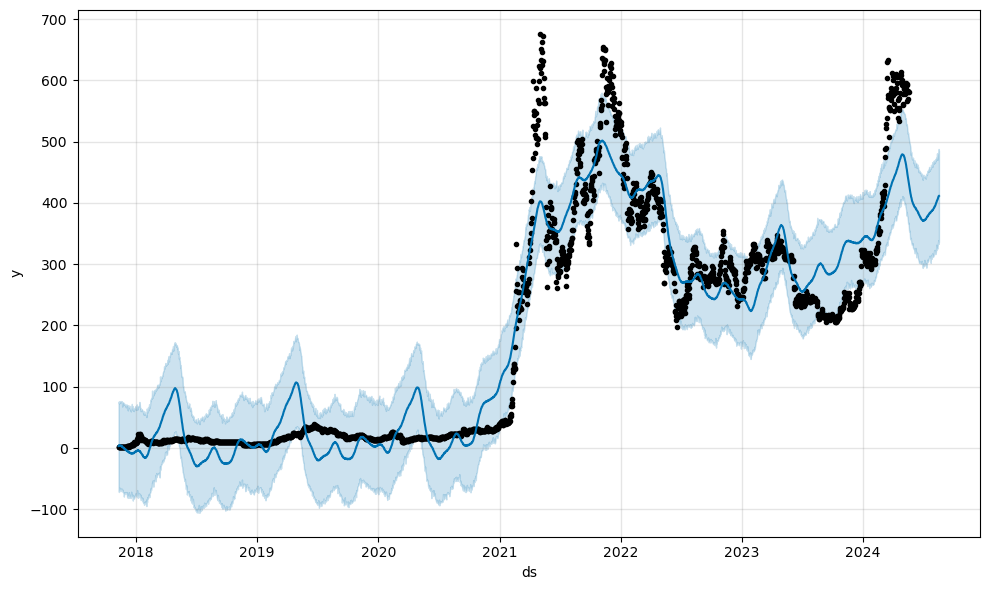

In [20]:
# Plot the Prophet predictions for the data
fig1 = crypto_model.plot(crypto_forecast)

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,424.668308,354.915195,498.284816
2024-05-21,421.163482,349.819136,496.939215
2024-05-22,418.600623,341.726403,493.529007
2024-05-23,415.563981,340.518597,490.481842
2024-05-24,413.112782,342.982707,478.200578
...,...,...,...
2024-08-13,405.855877,328.833679,478.033132
2024-08-14,407.930223,334.750372,481.093927
2024-08-15,409.293950,339.228668,481.309441


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

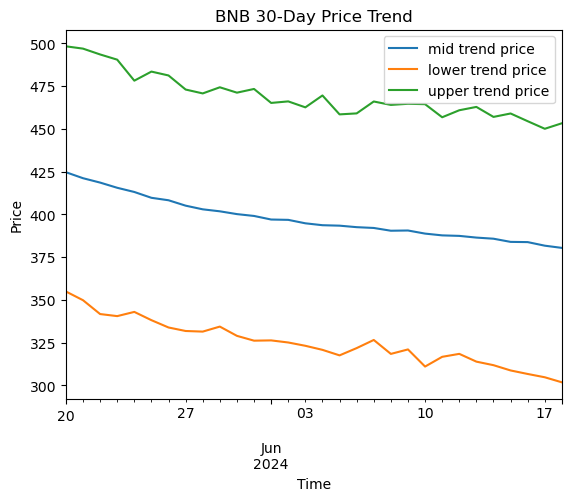

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

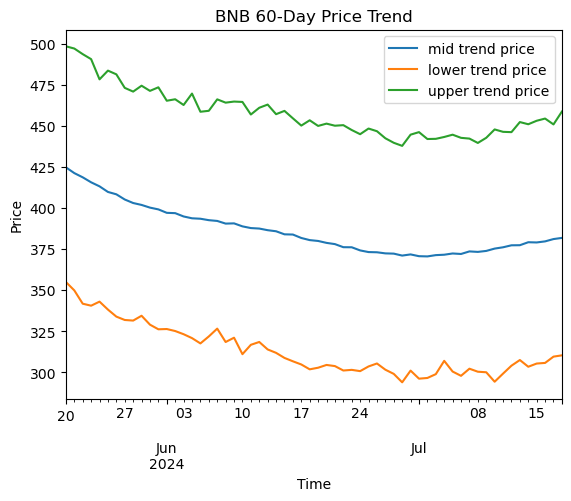

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

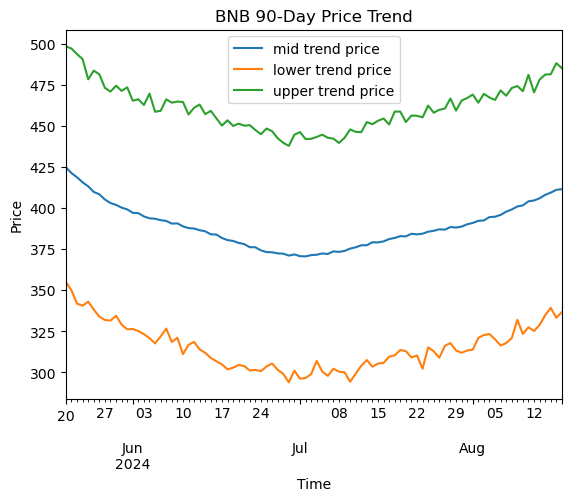

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

580.305542

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

424.66830783719746

In [29]:
# Retrieve mid trend price in 30 days
mid_trend_price_in_30 = crypto_forecast['mid trend price'].iloc[-60]
mid_trend_price_in_30

379.8912865682563

In [30]:
# Retrieve mid trend price in 60 days
mid_trend_price_in_60 = crypto_forecast['mid trend price'].iloc[-30]
mid_trend_price_in_60

382.81167405153667

In [31]:
# Retrieve mid trend price in 90 days
mid_trend_price_in_90 = crypto_forecast['mid trend price'].iloc[-1]
mid_trend_price_in_90

411.39658222261636

In [32]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30.round(3)

-0.345

In [33]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60.round(3)

-0.34

In [34]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90.round(3)

-0.291

In [35]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

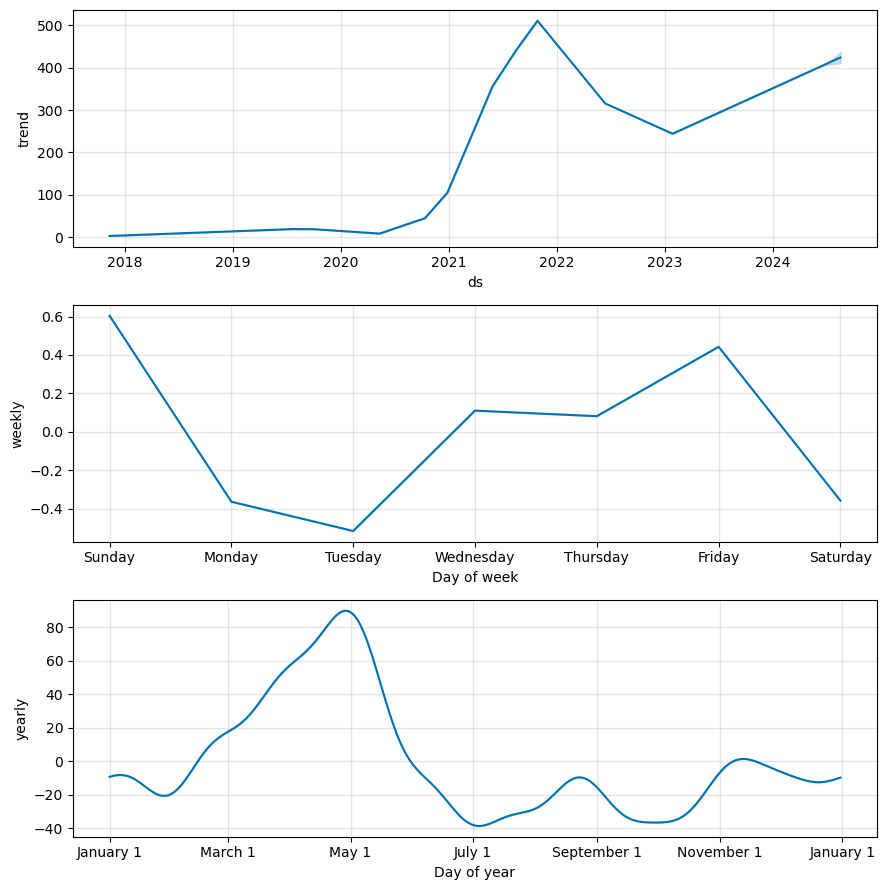

In [36]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig2 = crypto_model.plot_components(crypto_forecast)

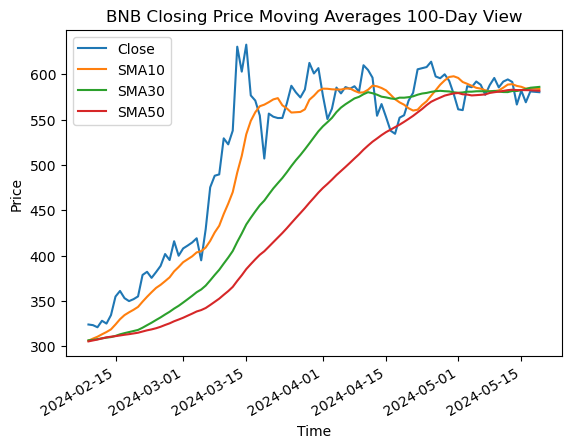

In [37]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

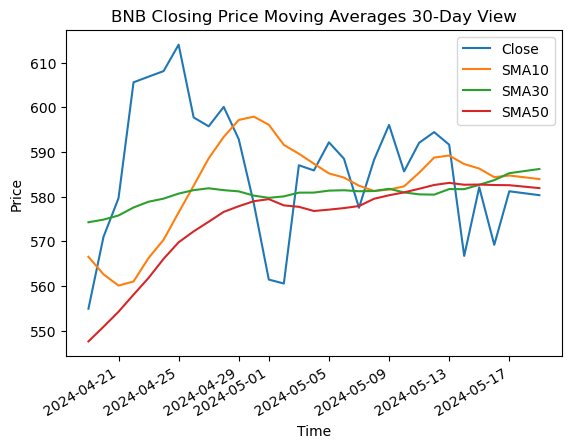

In [38]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.show()

In [39]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-19
File created :  2024-05-19.csv


In [40]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [41]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.481067,-0.006935356560101691,-0.07859463805561773,0.23472349758660838
BNB,580.305542,-0.34535988531321604,-0.3403273855834782,-0.29106901029282883

